In [57]:
import numpy as np
from SALib.sample import fast_sampler
from SALib.analyze import sobol
from SALib.analyze import fast
import matplotlib.pyplot as plt
from SALib import ProblemSpec
from SALib.sample import saltelli

##########################
#http0.1://salib.readthedocs.io/en/latest/basics_with_interface.html
##########################
import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52 as pa52
import Pacejka52_Sv_Sh_0 as pa52_0

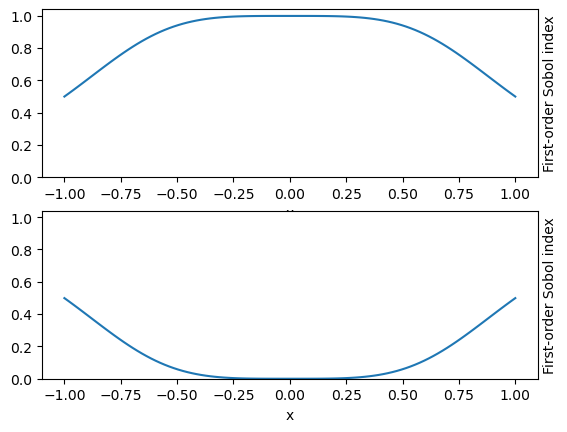

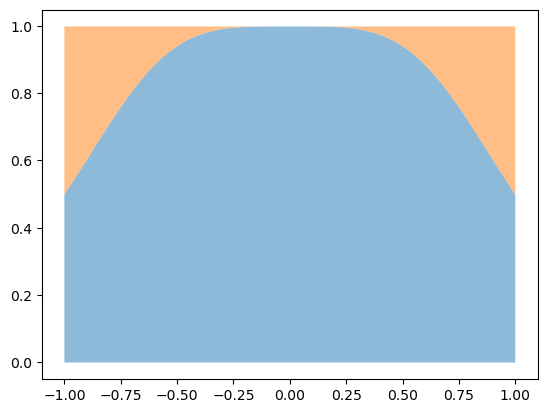

In [4]:
def parabola(x, a, b):
    """Return y = a + b*x**2."""
    return a + b*x**2


problem = {
    'num_vars': 2,
    'names': ['a', 'b'],
    'bounds': [[0, 1]]*2
}



X = fast_sampler.sample(problem, 100)

x1 = np.linspace(-1, 1, 100)
y1 = np.array([parabola(x1, *params) for params in X])

Si = [fast.analyze(problem, Y) for Y in y1.T]

S1s = np.array([s['S1'] for s in Si])

fig, ax = plt.subplots(2)

for i in range(0,2):
    ax[i].plot(x1, S1s[:, i])
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("First-order Sobol index")
    ax[i].set_ylim(0, 1.04)
    ax[i].yaxis.set_label_position("right")

plt.show()

s1_plt = np.array([x+y for x,y in zip(S1s[:, 0], S1s[:, 1])]) 
plt.figure(1)
plt.fill_between(x1, S1s[:, 0],0, alpha=0.5, label = 'a')
plt.fill_between(x1, S1s[:, 0], s1_plt,where = (s1_plt > S1s[:, 0]) , alpha=0.5, label = 'b')

In [58]:
Fz = -4000
#function
def Pacejka5_long_fit(SL,B,C,D,E):

    Fx=-Fz* D * np.sin(C * np.arctan(D * SL - E * (B*SL - np.arctan(B * SL)))) 
    
    return Fx

s=0.1
problem = {
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[-9.06434405*(1+s),-9.06434405*(1-s)], [1.60162373*(1-s), 1.60162373*(1+s)], [-1.72069169*(1+s), -1.72069169*(1-s)], [-0.80265574 * (1+s), -0.80265574*(1-s)]],
    #'bounds': [[4,12], [1, 2], [0.1,1.9], [-10, 1]],
}
SL = np.linspace(-1,1,100)

def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = Pacejka5_long_fit(SL,B,C,D,E)

    return y

X = fast_sampler.sample(problem, 6500)
################################################################
#Filter
################################################################
import copy
a = copy.deepcopy(X)
print(len(a))
SL_filt = np.linspace(0,1,100)

def entferne_nullzeilen(matrix):
    return [zeile for zeile in matrix if any(zeile)]

params2 = [9.06434405,  1.60162373, 1.72069169, -0.80265574]
F_ref = Pacejka5_long_fit(SL_filt, *params2)
#Filter
bound_lower = pa52_0.Pacejka52_long(1500,SL,0,3114)[0]
bound_upper = pa52_0.Pacejka52_long(5000,SL,0,3114)[0]

for i in range(0,len(a)):
    params1 = a[i,:]
    F = Pacejka5_long_fit(SL_filt, *params1)
    
    #alle negativen Werte raus
    for j in range(0,len(F)):
        if F[j] < 0:
            a[i,:] = 0
            break
        else:
            continue
        
    #alle die eine zu flache Kurve haben
    
    #F_max = np.max(F)
    #F_max_ref = np.max(F_ref)
    #if F_max * 0.5 < F_max_ref < F_max * 1.5:
    #    continue
        # a[i,:] = 0
   # else:
   #    a[i,:] = 0
        
    #laenge = int(len(F)/4)
    #if F[laenge] < 6000: 
    #    a[i,:] = 0
    #         
    #else:
    #    continue

    #zwei neue kurven die den ganzen definitionbereich definieren

    #for j in range(40,len(F)):
    #    if  F[j] > bound_upper[j] :
    #       a[i,:] = 0
    #    else:
    #       continue

    #for j in range(40,len(F)):
    #    if  F[j] < bound_lower[j] :
    #       a[i,:] = 0
    #    else:
    #       continue

a_neu = entferne_nullzeilen(a)

#check if its a multiply of D (=number of parameters)
def entferne_zeilen(matrix, anzahl_zeilen):
    return matrix[:-anzahl_zeilen]

if len(a_neu) % len(a_neu[0]) == 0:
    a_SA = a_neu
else:
    anzahl = len(a_neu) % len(a_neu[0])
    a_SA = entferne_zeilen(a_neu, anzahl)

################################################################

y1 = np.array([Pacejka5_long_fit(SL, *params) for params in a_SA])

Si = [fast.analyze(problem, Y) for Y in y1.T]

S1s = np.array([s['S1'] for s in Si])
STs = np.array([s['ST'] for s in Si])

S1s_B  = np.array(S1s[:,0])
S1s_C  = np.array(S1s[:,1])
S1s_D  = np.array(S1s[:,2])
S1s_E  = np.array(S1s[:,3])

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

plt.figure(2, figsize=(10,10))
plt.fill_between(SL,S1s_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,S1s_B,S1s_C_plt, where = (S1s_C_plt > S1s_B), alpha=0.5, label = 'C')
plt.fill_between(SL,S1s_C_plt,S1s_D_plt, where = (S1s_D_plt > S1s_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,S1s_D_plt,S1s_E_plt, where = (S1s_E_plt > S1s_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('FAST Index first-order')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


STs_B  = np.array(STs[:,0])
STs_C  = np.array(STs[:,1])
STs_D  = np.array(STs[:,2])
STs_E  = np.array(STs[:,3])

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

plt.figure(3, figsize=(10,10))
plt.fill_between(SL,STs_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,STs_B,STs_C_plt, where = (STs_C_plt > STs_B), alpha=0.5, label = 'C')
plt.fill_between(SL,STs_C_plt,STs_D_plt, where = (STs_D_plt > STs_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,STs_D_plt,STs_E_plt, where = (STs_E_plt > STs_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol total Index ')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


NameError: name 'sample_sobol' is not defined

In [63]:
Fz = -4000
#function
def Pacejka5_long_fit(SL,B,C,D,E):

    Fx=-Fz* D * np.sin(C * np.arctan(D * SL - E * (B*SL - np.arctan(B * SL)))) 
    
    return Fx

s=0,9
problem = {
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[-9.06434405*(1+s),-9.06434405*(1-s)], [1.60162373*(1-s), 1.60162373*(1+s)], [-1.72069169*(1+s), -1.72069169*(1-s)], [-0.80265574 * (1+s), -0.80265574*(1-s)]],
    #'bounds': [[4,12], [1, 2], [0.1,1.9], [-10, 1]],
}
SL = np.linspace(0,1,100)

def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = Pacejka5_long_fit(SL,B,C,D,E)

    return y

X = fast_sampler.sample(problem, 6500)

y1 = np.array([Pacejka5_long_fit(SL, *params) for params in a_SA])

Si = [fast.analyze(problem, Y) for Y in y1.T]

S1s = np.array([s['S1'] for s in Si])
STs = np.array([s['ST'] for s in Si])

S1s_B  = np.array(S1s[:,0])
S1s_C  = np.array(S1s[:,1])
S1s_D  = np.array(S1s[:,2])
S1s_E  = np.array(S1s[:,3])

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

plt.figure(2, figsize=(10,10))
plt.fill_between(SL,S1s_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,S1s_B,S1s_C_plt, where = (S1s_C_plt > S1s_B), alpha=0.5, label = 'C')
plt.fill_between(SL,S1s_C_plt,S1s_D_plt, where = (S1s_D_plt > S1s_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,S1s_D_plt,S1s_E_plt, where = (S1s_E_plt > S1s_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('FAST Index first-order')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


STs_B  = np.array(STs[:,0])
STs_C  = np.array(STs[:,1])
STs_D  = np.array(STs[:,2])
STs_E  = np.array(STs[:,3])

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

plt.figure(3, figsize=(10,10))
plt.fill_between(SL,STs_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,STs_B,STs_C_plt, where = (STs_C_plt > STs_B), alpha=0.5, label = 'C')
plt.fill_between(SL,STs_C_plt,STs_D_plt, where = (STs_D_plt > STs_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,STs_D_plt,STs_E_plt, where = (STs_E_plt > STs_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol total Index ')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

26000
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

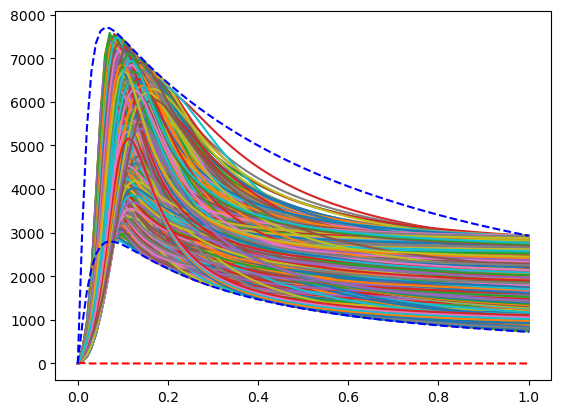

In [50]:
import copy
a = copy.deepcopy(X)
print(len(a))
SL = np.linspace(0,1,100)

def entferne_nullzeilen(matrix):
    return [zeile for zeile in matrix if any(zeile)]

params2 = [18.566518429399228, 2.0, -1.82504605, 510000.0]
F_ref = Pacejka5_long_fit(SL, *params2)
#Filter

bound_lower = pa52_0.Pacejka52_long(1500,SL,0,3114)[0]
bound_upper = pa52_0.Pacejka52_long(5000,SL,0,3114)[0]

for i in range(0,len(a)):
    params1 = a[i,:]
    F = Pacejka5_long_fit(SL, *params1)
    print(F[0])
    #alle negativen Werte raus
    for j in range(0,len(F)):
        if F[j] < 0:
            a[i,:] = 0
            break
        else:
            continue
        
    #alle die eine zu flache Kurve haben
    
    #F_max = np.max(F)
    #F_max_ref = np.max(F_ref)
    #if F_max * 0.5 < F_max_ref < F_max * 1.5:
    #    continue
        # a[i,:] = 0
   # else:
   #    a[i,:] = 0
        
    #laenge = int(len(F)/4)
    #if F[laenge] < 6000: 
    #    a[i,:] = 0
    #         
    #else:
    #    continue

    #zwei neue kurven die den ganzen definitionbereich definieren

    for j in range(8,len(F)):
        if  F[j] > bound_upper[j] :
           a[i,:] = 0
        else:
           continue

    for j in range(8,len(F)):
        if  F[j] < bound_lower[j] :
           a[i,:] = 0
        else:
           continue

a_neu = entferne_nullzeilen(a)

#check if its a multiply of D (=number of parameters)
def entferne_zeilen(matrix, anzahl_zeilen):
    return matrix[:-anzahl_zeilen]

if len(a_neu) % len(a_neu[0]) == 0:
    a_SA = a_neu
else:
    anzahl = len(a_neu) % len(a_neu[0])
    a_SA = entferne_zeilen(a_neu, anzahl)

print(len(a_SA))
for i in range(0,len(a_SA)):
    params_plot = a_SA[i]
    F_plot = Pacejka5_long_fit(SL, *params_plot)
    plt.plot(SL,F_plot)


plt.plot(SL,F_ref, 'r--')
plt.plot(SL,bound_lower, 'b--')
plt.plot(SL,bound_upper, 'b--')


In [7]:
len(a_neu[0])

4